In [14]:
import warnings
import sys 
import os    
import glob
from functools import reduce
import numpy as np
from brainiak.eventseg.event import EventSegment
from scipy.stats import norm

from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import nilearn as nl
from nilearn import plotting, image, masking
from nilearn.maskers import NiftiLabelsMasker
smallsize=14; mediumsize=16; largesize=18
plt.rc('xtick', labelsize=smallsize); plt.rc('ytick', labelsize=smallsize); plt.rc('legend', fontsize=mediumsize)
plt.rc('figure', titlesize=largesize); plt.rc('axes', labelsize=mediumsize); plt.rc('axes', titlesize=mediumsize)
from pathlib import Path
output_dir = Path.cwd() / "images" 
output_dir.mkdir(exist_ok=True, parents=True)
print(f"Output will be saved to: {output_dir}")

Output will be saved to: C:\Users\izika\OneDrive\Documents\Hebrew U\Modeling of cognition\brainiak\docs\examples\eventseg\images


In [6]:
from nilearn import datasets
print(f"Datasets are stored in: {datasets.get_data_dirs()!r}")

Datasets are stored in: ['C:\\Users\\izika/nilearn_data']


(61, 73, 61, 523)
(61, 73, 61)


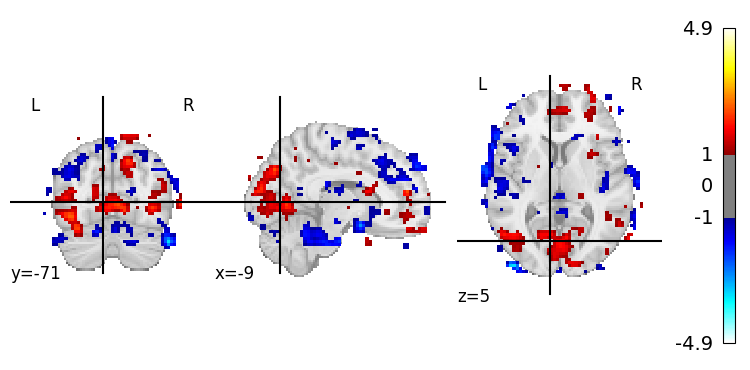

In [7]:
file = r'C:\Users\izika\OneDrive\Documents\ComDePri\Memory\fMRI data Project\RecallFiles_published\recall_files\sherlock_recall_s1.nii'
# file = '/home/itzik/Desktop/EventBoundaries/recall_files/sherlock_recall_s1.nii'
all_TR = image.load_img(file)
print(all_TR.shape)
first_TR = image.index_img(file, 0)
print(first_TR.shape)

plotting.plot_stat_map(first_TR, threshold=1)#, output_file=output_dir / "first_TR.png")
# first_TR.to_filename(output_dir / "first_TR.nii.gz")

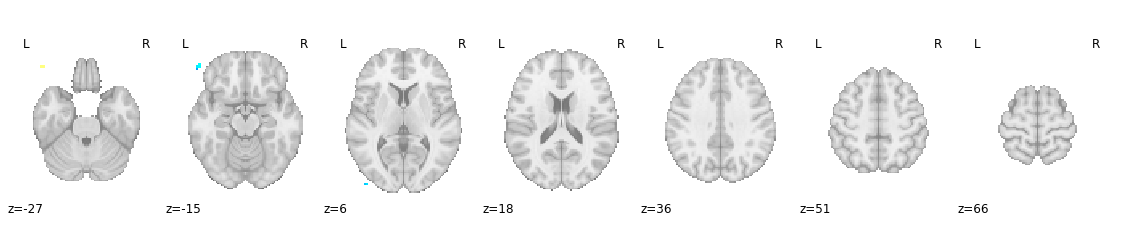

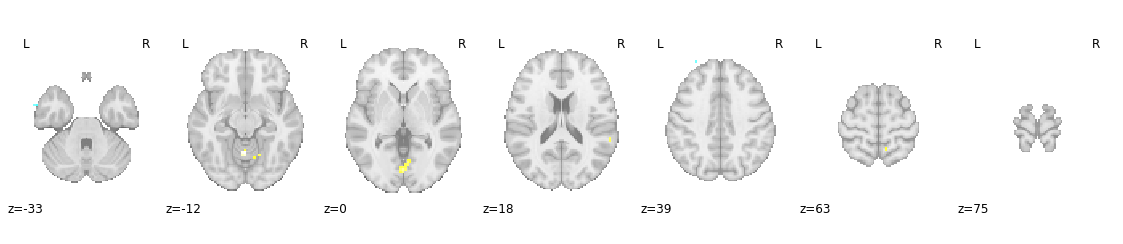

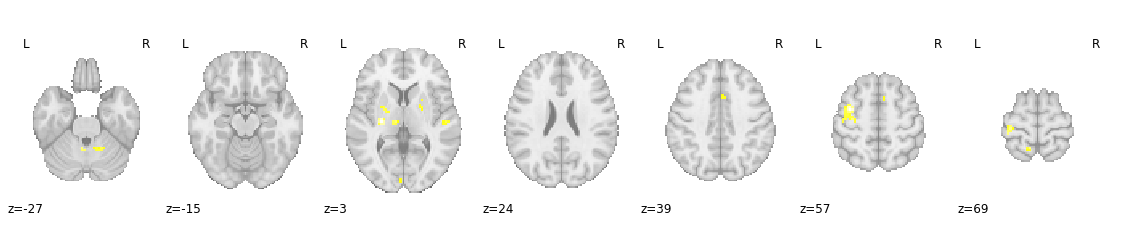

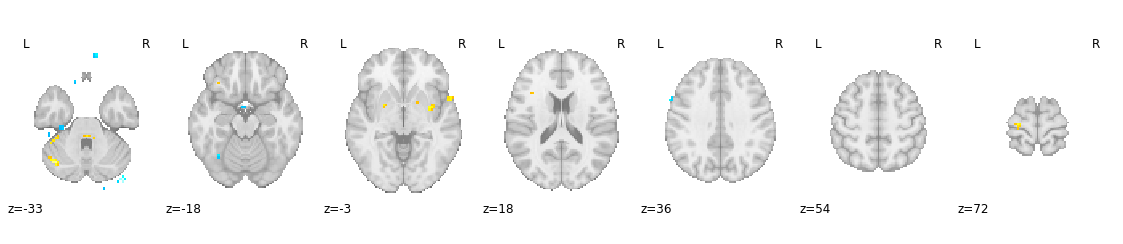

In [74]:
for img in image.iter_img(image.index_img(file, np.arange(0, 4, 1))):
    # img is now an in-memory 3D img
    plotting.plot_stat_map(
        img, threshold=3, display_mode="z",  colorbar=False
    )


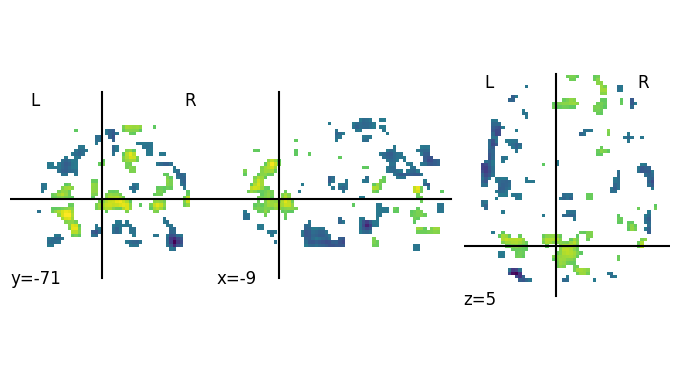

In [8]:
plotting.plot_img(image.smooth_img(first_TR, fwhm=2), threshold=1)

In [37]:
atlas = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm")

# The first label correspond to the background
print(f"The atlas contains {len(atlas.labels) - 1} non-overlapping regions")

The atlas contains 48 non-overlapping regions


# ROI Selection 
### high level regions:
Define DMN ROIs based on Baldassano et al. 2018 (https://www.jneurosci.org/content/38/45/9689), using Yeo 15,16,17 networks and merging spatailly contiguous regions.
This yielded six ROIs: angular gyrus (1868 vertices), superior temporal sulcus (STS, 2118 vertices), SFG (2461 vertices),mPFC (2069 vertices), parahippocampal cortex (PHC, 882 vertices), and PMC (2495 vertices).
 
Additionally, use the freesurfer subcortical parcellation to extract the **hippocampus** as a ROI (Hipp, 1289 voxels).


In [38]:
# resmaple atlas to match 3mm data
atlas.maps = image.resample_to_img(atlas.maps, all_TR, interpolation="nearest")

In [46]:
label = 'Angular Gyrus' ; label_index = atlas.labels.index(label)
bool_mask = atlas.maps.get_fdata() == label_index
mask_img = nl.image.new_img_like(atlas.maps, bool_mask)
print(label, "mask // Shape:", bool_mask.shape, ", # voxels: ", np.sum(bool_mask))

Angular Gyrus mask // Shape: (61, 73, 61) , # voxels:  667


In [81]:
masked = masking.apply_mask([first_TR], mask_img, dtype='f', smoothing_fwhm=None, ensure_finite=True)
masked.shape

(1, 667)

In [80]:
np.mean(masked)

1.7775023e-06